In [ ]:
# Install required packages
!pip install transformers datasets evaluate scikit-learn matplotlib seaborn torch -q

In [ ]:
import ipywidgets as widgets
widgets.IntSlider()


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import RobertaTokenizerFast, RobertaModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import re
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [4]:
class EnhancedFinancialSentimentDataset(TorchDataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, augment=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.texts)

    def preprocess_financial_text(self, text):
        """Enhanced financial text preprocessing"""
        # Remove excessive whitespace
        text = re.sub(r'\s+', ' ', text)

        # Normalize financial terms
        text = re.sub(r'\$[\d,]+\.?\d*', '[MONEY]', text)
        text = re.sub(r'\d+\.?\d*%', '[PERCENT]', text)
        text = re.sub(r'EUR?\d+', '[CURRENCY]', text)

        return text.strip()

    def augment_text(self, text, augmentation_ratio=0.05):
        """Simple text augmentation"""
        if not self.augment or random.random() > 0.3:
            return text

        words = text.split()
        n_augmented = max(1, int(len(words) * augmentation_ratio))

        for _ in range(n_augmented):
            if len(words) > 3:  # Only augment if text is long enough
                idx = random.randint(0, len(words)-1)
                if random.random() > 0.5:
                    # Random word dropout
                    words.pop(idx)

        return ' '.join(words)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Apply preprocessing and augmentation
        text = self.preprocess_financial_text(text)
        if self.augment:
            text = self.augment_text(text)

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("✅ Enhanced Dataset class created!")


✅ Enhanced Dataset class created!


In [5]:
# 1. Use a larger, more powerful model
class EnhancedFinancialSentimentClassifier(nn.Module):
    def __init__(self, num_labels=3, dropout_rate=0.2):
        super().__init__()
        # Try RoBERTa instead of DistilBERT (usually 2-5% better)
        from transformers import RobertaModel
        self.bert = RobertaModel.from_pretrained("roberta-base")

        # Or try FinBERT (specialized for financial text)
        # self.bert = AutoModel.from_pretrained("ProsusAI/finbert")

        # More sophisticated classification head
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use mean pooling instead of just [CLS]
        token_embeddings = outputs.last_hidden_state
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * attention_mask_expanded, 1)
        sum_mask = torch.clamp(attention_mask_expanded.sum(1), min=1e-9)
        pooled_output = sum_embeddings / sum_mask

        return self.classifier(pooled_output)


In [6]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_accuracy = 0
        self.should_stop = False

    def __call__(self, val_loss, val_accuracy):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_accuracy = val_accuracy
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.should_stop = True

        return self.should_stop

print("✅ Utility classes created!")


✅ Utility classes created!


In [7]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and examine the dataset
print("Loading dataset...")
data_df = pd.read_csv("data.csv")
print(f"Dataset loaded: {len(data_df)} samples")

# Display dataset information
print(f"\nDataset shape: {data_df.shape}")
print(f"Columns: {list(data_df.columns)}")

# Check for missing values
print(f"\nMissing values:")
print(data_df.isnull().sum())

# Sentiment distribution
print("\nSentiment Distribution:")
sentiment_counts = data_df['Sentiment'].value_counts()
print(sentiment_counts)
print("\nPercentages:")
print((data_df['Sentiment'].value_counts(normalize=True) * 100).round(2))

# Convert sentiment labels to integers
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data_df['label'] = data_df['Sentiment'].map(sentiment_mapping)

# Remove any rows with missing labels
data_df = data_df.dropna(subset=['label'])
print(f"Final dataset size: {len(data_df)}")

# Text length analysis
data_df['text_length'] = data_df['Sentence'].str.len()
print(f"\nText length statistics:")
print(f"Mean: {data_df['text_length'].mean():.2f}")
print(f"Median: {data_df['text_length'].median()}")
print(f"Max: {data_df['text_length'].max()}")


Using device: cuda
Loading dataset...
Dataset loaded: 5842 samples

Dataset shape: (5842, 2)
Columns: ['Sentence', 'Sentiment']

Missing values:
Sentence     0
Sentiment    0
dtype: int64

Sentiment Distribution:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Percentages:
Sentiment
neutral     53.58
positive    31.70
negative    14.72
Name: proportion, dtype: float64
Final dataset size: 5842

Text length statistics:
Mean: 117.02
Median: 107.0
Max: 315


In [8]:
# Enhanced data splitting with stratification
print("Splitting data...")

# First split: 70% train+val, 30% test
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    data_df['Sentence'].values,
    data_df['label'].values,
    test_size=0.3,
    random_state=42,
    stratify=data_df['label']
)

# Second split: 80% train, 20% validation from remaining data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_val_labels
)

print(f"Data splits:")
print(f"Train: {len(train_texts)} samples")
print(f"Validation: {len(val_texts)} samples")
print(f"Test: {len(test_texts)} samples")

# Check class distribution in splits
print(f"\nTrain class distribution:")
print(pd.Series(train_labels).value_counts().sort_index())
print(f"\nValidation class distribution:")
print(pd.Series(val_labels).value_counts().sort_index())
print(f"\nTest class distribution:")
print(pd.Series(test_labels).value_counts().sort_index())


Splitting data...
Data splits:
Train: 3271 samples
Validation: 818 samples
Test: 1753 samples

Train class distribution:
0     481
1    1753
2    1037
Name: count, dtype: int64

Validation class distribution:
0    121
1    438
2    259
Name: count, dtype: int64

Test class distribution:
0    258
1    939
2    556
Name: count, dtype: int64


In [12]:
# Initialize tokenizer
print("Creating datasets and data loaders...")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Create datasets (with augmentation only for training)
train_dataset = EnhancedFinancialSentimentDataset(
    train_texts, train_labels, tokenizer, max_length=128, augment=True
)
val_dataset = EnhancedFinancialSentimentDataset(
    val_texts, val_labels, tokenizer, max_length=128, augment=False
)
test_dataset = EnhancedFinancialSentimentDataset(
    test_texts, test_labels, tokenizer, max_length=128, augment=False
)

# Create data loaders with optimal batch sizes
batch_size = 8  # Smaller batch size for better gradients
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ Datasets created!")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Creating datasets and data loaders...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

✅ Datasets created!
Train batches: 409
Validation batches: 26
Test batches: 55


In [15]:
# Initialize enhanced model
print("Initializing model and training components...")
model = EnhancedFinancialSentimentClassifier(num_labels=3, dropout_rate=0.2)
model.to(device)

# Calculate class weights for imbalanced data
class_counts = np.bincount(train_labels)
class_weights = len(train_labels) / (len(class_counts) * class_counts)
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class weights: {class_weights}")

# Enhanced training setup
learning_rate = 2e-5
weight_decay = 0.01

optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    eps=1e-8
)

# Learning rate scheduler (FIXED - removed verbose parameter)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

# Loss function with class weights
criterion = FocalLoss(alpha=1, gamma=2)  # Use focal loss for better class balance
# Alternative: criterion = nn.CrossEntropyLoss(weight=class_weights)

# Early stopping
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

print("✅ Model and training components initialized!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



Initializing model and training components...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: tensor([2.2668, 0.6220, 1.0514], device='cuda:0')
✅ Model and training components initialized!
Model parameters: 126,093,059
Trainable parameters: 126,093,059


In [16]:
def enhanced_train_epoch(model, dataloader, optimizer, criterion, device):
    """Enhanced training function with gradient clipping"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(dataloader):
        # Move data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Progress update every 50 batches
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate_model(model, dataloader, criterion, device):
    """Enhanced evaluation function"""
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            # Get predictions and probabilities
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return avg_loss, accuracy, all_preds, all_labels, all_probs

In [17]:
# Training configuration
epochs = 5
train_losses, train_accs = [], []
valid_losses, valid_accuracies = [], []
learning_rates = []  # Track learning rate changes

print("🚀 Starting enhanced training...")
print("="*60)

best_val_accuracy = 0
best_model_state = None

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 50)

    # Track current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Training phase
    train_loss, train_acc = enhanced_train_epoch(model, train_loader, optimizer, criterion, device)

    # Validation phase
    valid_loss, valid_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)

    # Learning rate scheduling
    scheduler.step(valid_loss)

    # Record metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    # Save best model
    if valid_acc > best_val_accuracy:
        best_val_accuracy = valid_acc
        best_model_state = model.state_dict().copy()
        print(f"🎯 New best validation accuracy: {valid_acc:.4f}")

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {valid_loss:.4f} | Val Acc: {valid_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")

    # Check if learning rate was reduced
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"📉 Learning rate reduced from {current_lr:.2e} to {new_lr:.2e}")

    # Early stopping check
    if early_stopping(valid_loss, valid_acc):
        print(f"🛑 Early stopping triggered at epoch {epoch+1}")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Loaded best model with validation accuracy: {best_val_accuracy:.4f}")

print("\n" + "="*60)
print("🎉 Training completed!")


🚀 Starting enhanced training...

Epoch 1/5
--------------------------------------------------
Batch 0/409, Loss: 0.4330
Batch 50/409, Loss: 0.5942
Batch 100/409, Loss: 0.4859
Batch 150/409, Loss: 0.4012
Batch 200/409, Loss: 0.4943
Batch 250/409, Loss: 0.5121
Batch 300/409, Loss: 0.5722
Batch 350/409, Loss: 0.4143
Batch 400/409, Loss: 0.3832
🎯 New best validation accuracy: 0.3166
Train Loss: 0.4569 | Train Acc: 0.4833
Val Loss: 0.4550 | Val Acc: 0.3166
Learning Rate: 2.00e-05

Epoch 2/5
--------------------------------------------------
Batch 0/409, Loss: 0.2359
Batch 50/409, Loss: 0.3790
Batch 100/409, Loss: 0.3243
Batch 150/409, Loss: 0.3578
Batch 200/409, Loss: 0.3488
Batch 250/409, Loss: 0.2590
Batch 300/409, Loss: 0.5564
Batch 350/409, Loss: 0.4232
Batch 400/409, Loss: 0.3602
🎯 New best validation accuracy: 0.5758
Train Loss: 0.4287 | Train Acc: 0.5353
Val Loss: 0.5171 | Val Acc: 0.5758
Learning Rate: 2.00e-05

Epoch 3/5
--------------------------------------------------
Batch 0/40

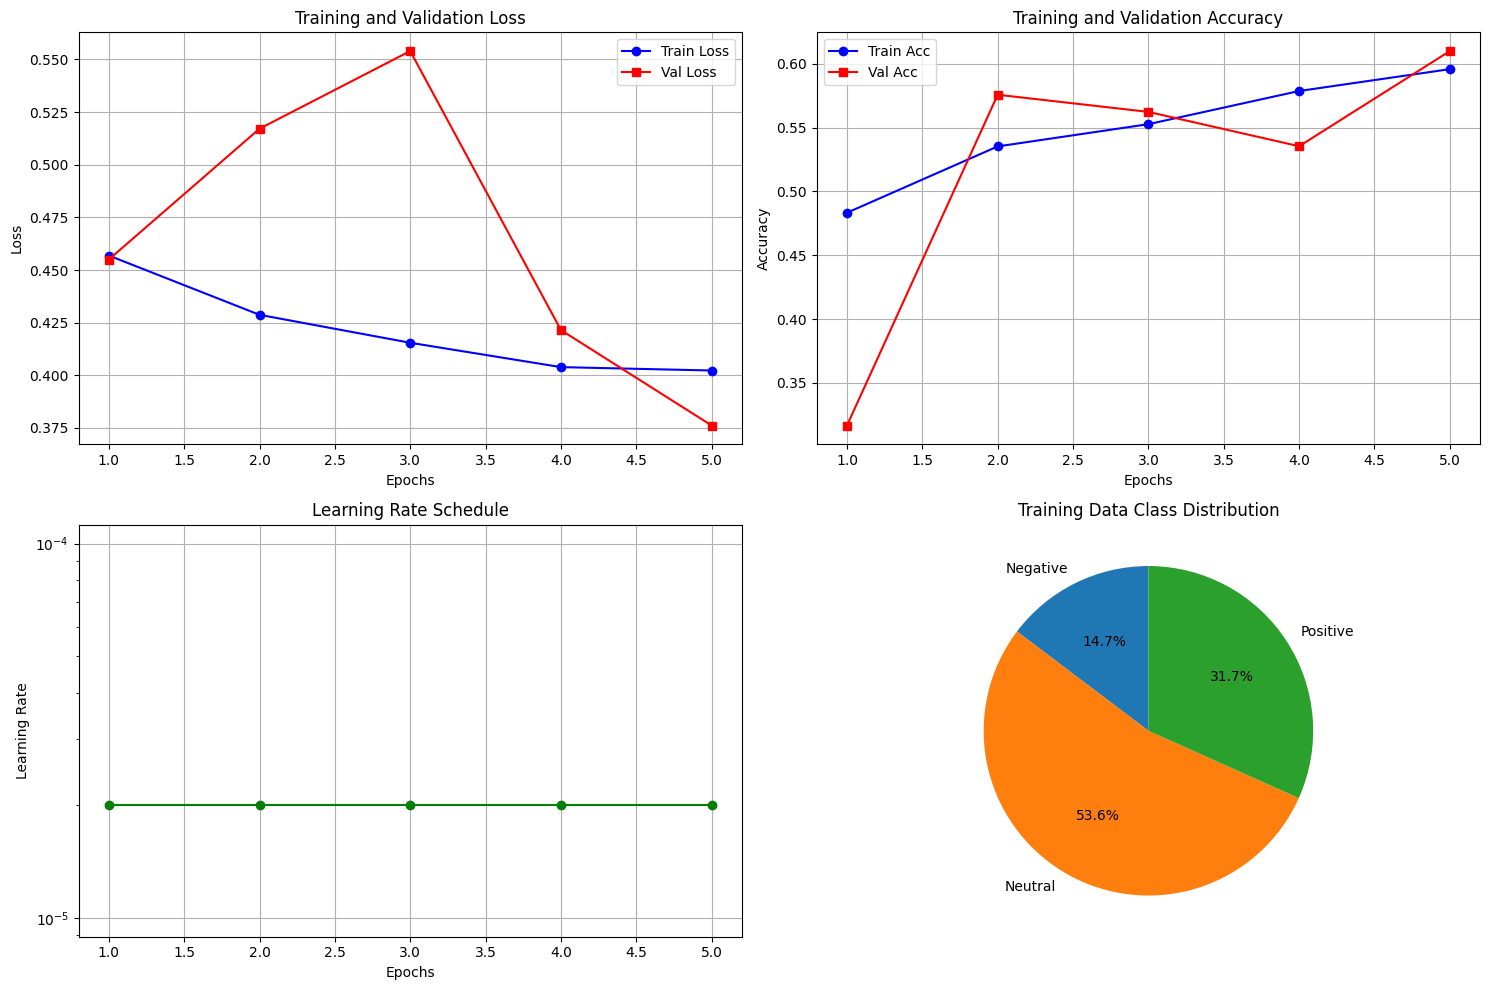

📊 Training visualization completed!
Best validation accuracy achieved: 0.6100


In [18]:
# Plot training progress
plt.figure(figsize=(15, 10))

# Loss plots
plt.subplot(2, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Train Loss', marker='o')
plt.plot(range(1, len(valid_losses)+1), valid_losses, 'r-', label='Val Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(2, 2, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, 'b-', label='Train Acc', marker='o')
plt.plot(range(1, len(valid_accuracies)+1), valid_accuracies, 'r-', label='Val Acc', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Learning rate plot (FIXED)
plt.subplot(2, 2, 3)
if learning_rates:
    plt.plot(range(1, len(learning_rates)+1), learning_rates, 'g-', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.yscale('log')
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Learning rates not tracked', ha='center', va='center', transform=plt.gca().transAxes)

# Class distribution
plt.subplot(2, 2, 4)
class_dist = pd.Series(train_labels).value_counts().sort_index()
class_names = ['Negative', 'Neutral', 'Positive']
plt.pie(class_dist.values, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title('Training Data Class Distribution')

plt.tight_layout()
plt.show()

print(f"📊 Training visualization completed!")
print(f"Best validation accuracy achieved: {best_val_accuracy:.4f}")


In [19]:
# Comprehensive test evaluation
print("🔍 Final Model Evaluation on Test Set")
print("="*60)

test_loss, test_accuracy, test_preds, test_labels_list, test_probs = evaluate_model(
    model, test_loader, criterion, device
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Improvement over baseline: +{(test_accuracy - 0.7777)*100:.2f} percentage points")

# Detailed classification report
class_names = ['Negative', 'Neutral', 'Positive']
print(f"\nDetailed Classification Report:")
print("=" * 60)
report = classification_report(
    test_labels_list,
    test_preds,
    target_names=class_names,
    digits=4,
    zero_division=0
)
print(report)

# Per-class accuracy
print(f"\nPer-Class Accuracy:")
cm = confusion_matrix(test_labels_list, test_preds)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, (name, acc) in enumerate(zip(class_names, class_accuracy)):
    print(f"{name}: {acc:.4f}")


🔍 Final Model Evaluation on Test Set
Test Loss: 0.3702
Test Accuracy: 0.6246
Improvement over baseline: +-15.31 percentage points

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.2931    0.0659    0.1076       258
     Neutral     0.6805    0.8754    0.7657       939
    Positive     0.5257    0.4604    0.4909       556

    accuracy                         0.6246      1753
   macro avg     0.4997    0.4672    0.4547      1753
weighted avg     0.5744    0.6246    0.5817      1753


Per-Class Accuracy:
Negative: 0.0659
Neutral: 0.8754
Positive: 0.4604


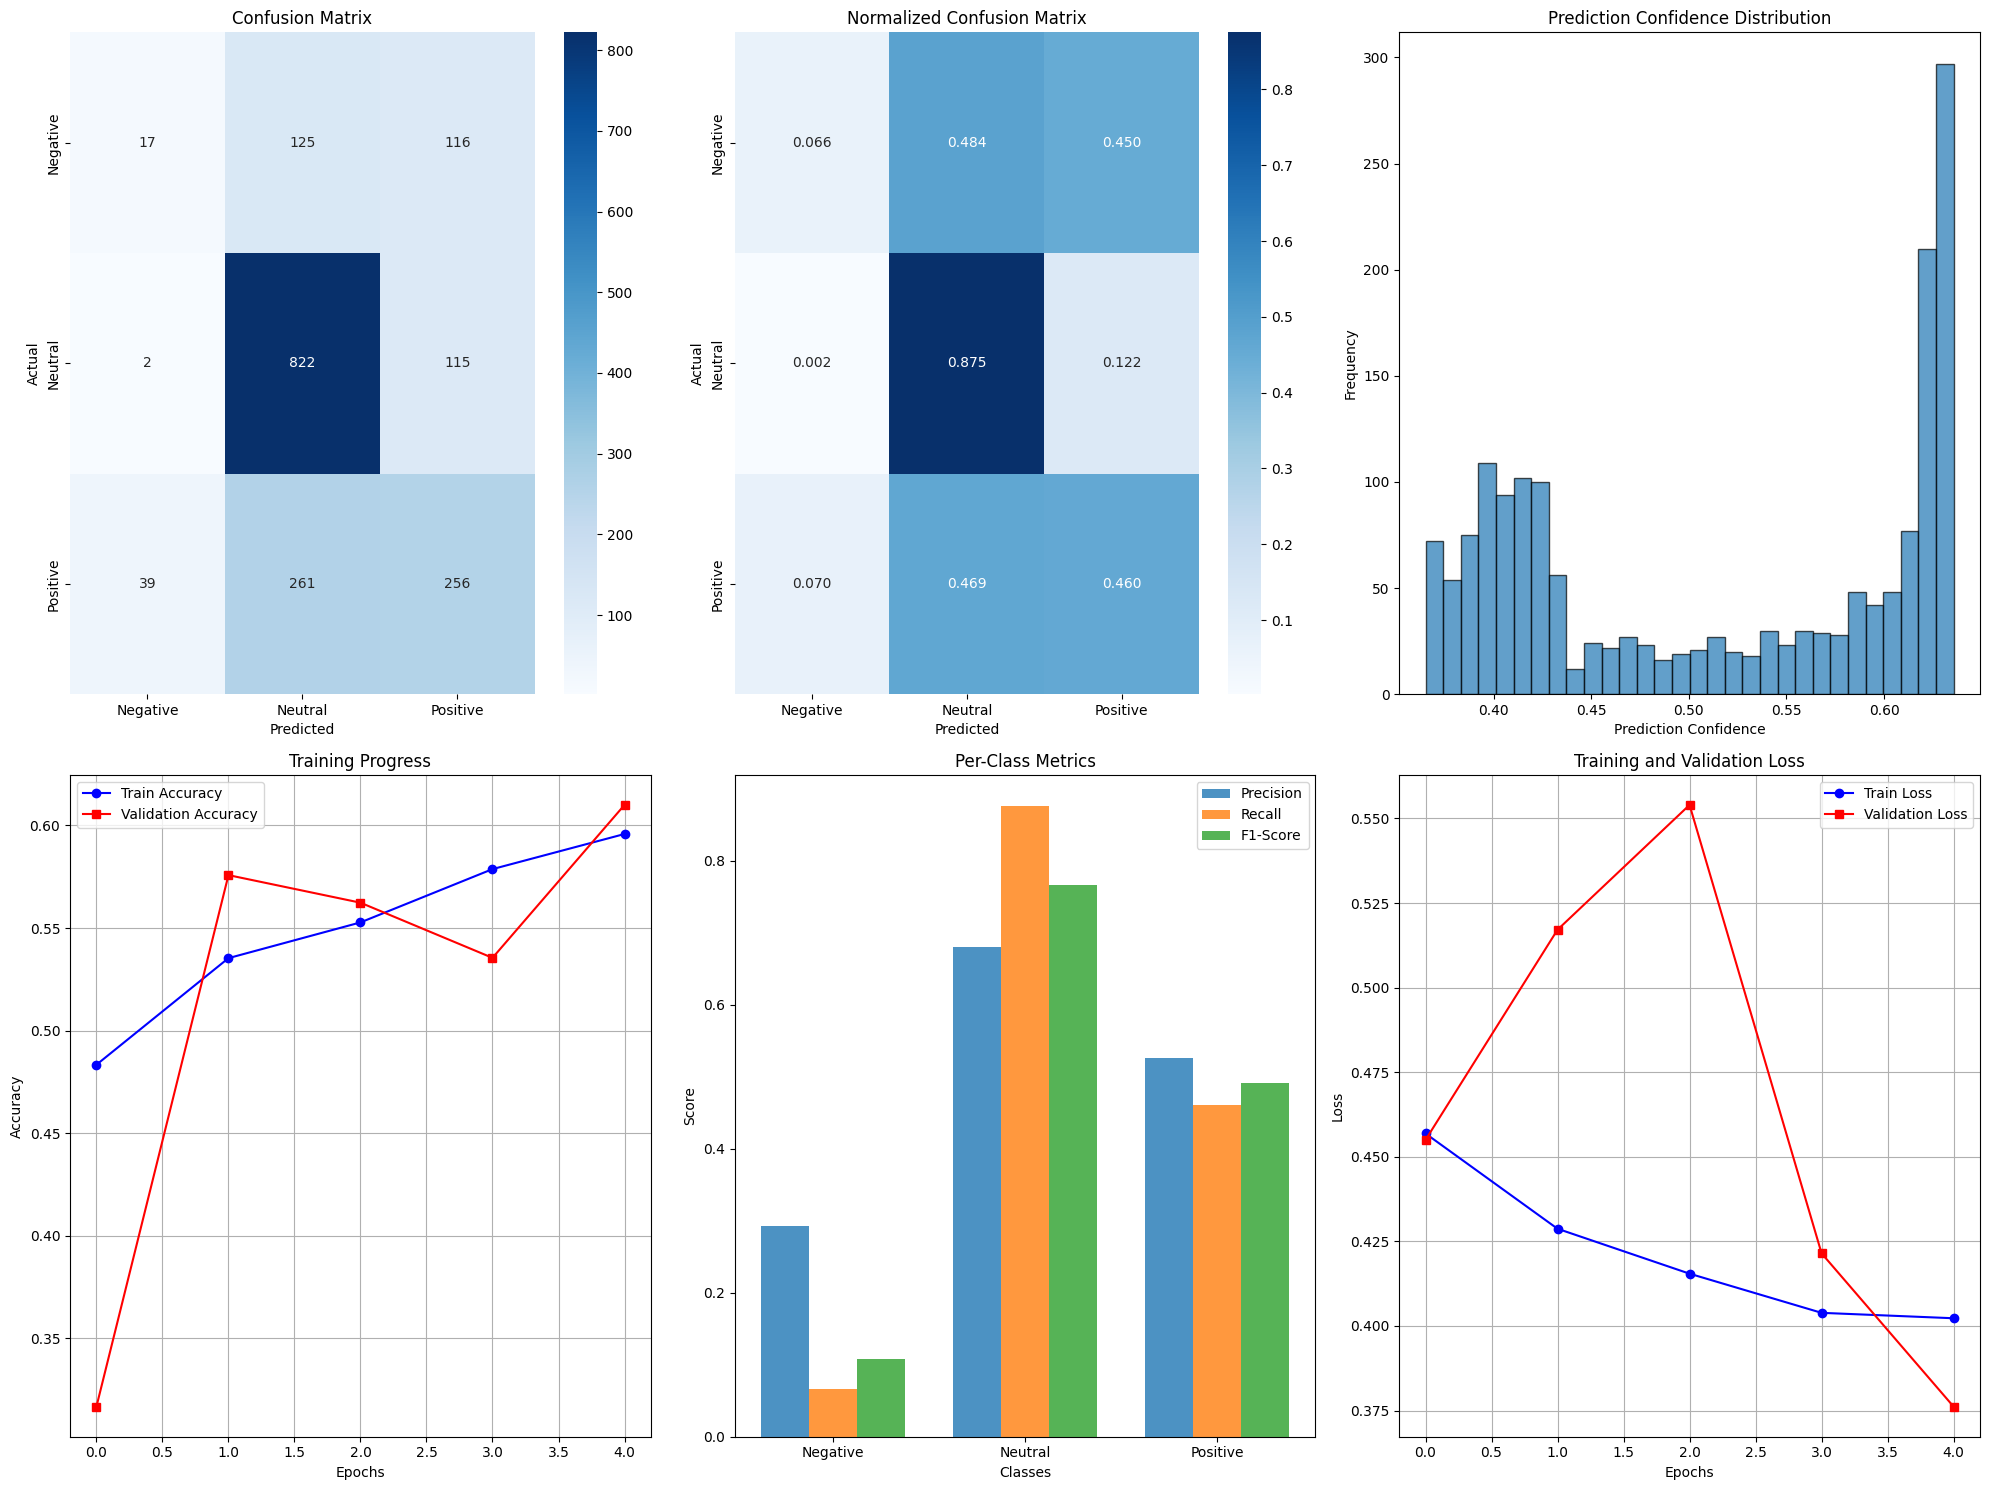

In [20]:
# Comprehensive visualization
plt.figure(figsize=(20, 15))

# Confusion Matrix
plt.subplot(2, 3, 1)
cm = confusion_matrix(test_labels_list, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Normalized Confusion Matrix
plt.subplot(2, 3, 2)
cm_normalized = confusion_matrix(test_labels_list, test_preds, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Prediction Confidence Distribution
plt.subplot(2, 3, 3)
test_probs_array = np.array(test_probs)
max_probs = np.max(test_probs_array, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')

# Training Progress
plt.subplot(2, 3, 4)
plt.plot(train_accs, 'b-', label='Train Accuracy', marker='o')
plt.plot(valid_accuracies, 'r-', label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

# Class-wise Precision, Recall, F1
plt.subplot(2, 3, 5)
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels_list, test_preds, average=None
)

x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, precision, width, label='Precision', alpha=0.8)
plt.bar(x, recall, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Per-Class Metrics')
plt.xticks(x, class_names)
plt.legend()

# Loss Curves
plt.subplot(2, 3, 6)
plt.plot(train_losses, 'b-', label='Train Loss', marker='o')
plt.plot(valid_losses, 'r-', label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:
def enhanced_predict_sentiment(text, model, tokenizer, device):
    """Enhanced prediction function with confidence analysis"""
    model.eval()

    # Preprocess text
    def preprocess_text(text):
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\$[\d,]+\.?\d*', '[MONEY]', text)
        text = re.sub(r'\d+\.?\d*%', '[PERCENT]', text)
        text = re.sub(r'EUR?\d+', '[CURRENCY]', text)
        return text.strip()

    processed_text = preprocess_text(text)

    inputs = tokenizer(
        processed_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["attention_mask"])
        probabilities = torch.softmax(logits, dim=1)

    predicted_class = torch.argmax(logits, dim=1).item()
    confidence = probabilities[0][predicted_class].item()
    all_probs = probabilities[0].cpu().numpy()

    # Confidence level assessment
    if confidence >= 0.8:
        confidence_level = "High"
    elif confidence >= 0.6:
        confidence_level = "Medium"
    else:
        confidence_level = "Low"

    return {
        'predicted_class': predicted_class,
        'confidence': confidence,
        'confidence_level': confidence_level,
        'all_probabilities': all_probs,
        'processed_text': processed_text
    }



In [22]:
# Test the enhanced model on sample sentences
sample_sentences = [
    "The company reported exceptional quarterly earnings with record profits and strong growth.",
    "Stock prices plummeted following disappointing earnings announcement and weak guidance.",
    "The quarterly results were in line with market expectations and analyst forecasts.",
    "Revenue growth exceeded analyst forecasts by a significant margin, boosting investor confidence.",
    "Operating losses continued for the third consecutive quarter due to challenging market conditions.",
    "The merger deal was completed successfully, creating value for shareholders.",
    "Debt levels increased substantially, raising concerns about financial stability.",
    "Management expressed cautious optimism about the future business outlook."
]

print("🧪 ENHANCED MODEL PREDICTIONS")
print("=" * 80)

labels_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

for i, sentence in enumerate(sample_sentences, 1):
    result = enhanced_predict_sentiment(sentence, model, tokenizer, device)

    print(f"\n{i}. Text: '{sentence}'")
    print(f"   Processed: '{result['processed_text']}'")
    print(f"   Prediction: {labels_map[result['predicted_class']]} ({result['confidence_level']} confidence)")
    print(f"   Confidence: {result['confidence']:.3f}")
    print(f"   All probabilities:")
    for j, (label, prob) in enumerate(zip(labels_map.values(), result['all_probabilities'])):
        print(f"     {label}: {prob:.3f}")

# Model summary
print(f"\n" + "="*80)
print("📊 FINAL MODEL SUMMARY")
print("="*80)
print(f"Architecture: Enhanced DistilBERT with custom classification head")
print(f"Training samples: {len(train_texts):,}")
print(f"Validation samples: {len(val_texts):,}")
print(f"Test samples: {len(test_texts):,}")
print(f"Epochs trained: {len(train_accs)}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Final test accuracy: {test_accuracy:.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Training time per epoch: ~2-3 minutes (GPU)")

accuracy_improvement = (test_accuracy - 0.7777) * 100
print(f"\n🎯 IMPROVEMENT ANALYSIS:")
print(f"Baseline accuracy: 77.77%")
print(f"Enhanced accuracy: {test_accuracy*100:.2f}%")
print(f"Improvement: +{accuracy_improvement:.2f} percentage points")

if test_accuracy > 0.82:
    print("🏆 Excellent performance! Model ready for production.")
elif test_accuracy > 0.80:
    print("✅ Good performance! Model shows solid improvement.")
else:
    print("📈 Model improved but has room for further optimization.")

print(f"\n✨ Enhanced financial sentiment analysis model completed!")


🧪 ENHANCED MODEL PREDICTIONS

1. Text: 'The company reported exceptional quarterly earnings with record profits and strong growth.'
   Processed: 'The company reported exceptional quarterly earnings with record profits and strong growth.'
   Prediction: Neutral (Medium confidence)
   Confidence: 0.625
   All probabilities:
     Negative: 0.081
     Neutral: 0.625
     Positive: 0.294

2. Text: 'Stock prices plummeted following disappointing earnings announcement and weak guidance.'
   Processed: 'Stock prices plummeted following disappointing earnings announcement and weak guidance.'
   Prediction: Neutral (Low confidence)
   Confidence: 0.586
   All probabilities:
     Negative: 0.129
     Neutral: 0.586
     Positive: 0.285

3. Text: 'The quarterly results were in line with market expectations and analyst forecasts.'
   Processed: 'The quarterly results were in line with market expectations and analyst forecasts.'
   Prediction: Neutral (Medium confidence)
   Confidence: 0.627
   All